Develops a custom convolutional neural network (CNN) to classify Alzheimer's disease, focusing on:
- Class weighting to address class imbalance
- Hyperparameter tuning
- Distributed training using TensorFlow's MirroredStrategy
- The effect of class imbalance on class-specific classification accuracy

In [0]:
# "standard"
import numpy as np

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

# misc
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training, multiclass_summary
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
data=load_pickle_s3(bucket_name, s3_file_name, dbutils)

train_data=data['train_data']
train_lab=data['train_labels']
test_data=data['test_data']
test_lab=data['test_labels']
class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Define custom CNN and distributed training strategy

In [0]:
def create_model():
    # three convolutional layers and one fully connected layer
    model = keras.Sequential([
        keras.Input(shape = (128, 128, 1)),

        keras.layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(
            filters=128, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'), # fully connected layer
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clear_output(wait=False)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Fit model

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history = model.fit(
    train_data, 
    train_lab_cat, 
    epochs=25, 
    batch_size=32, 
    validation_data=validation_data, 
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_custom_CNN.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_custom_CNN.pkl


Visualize model fit

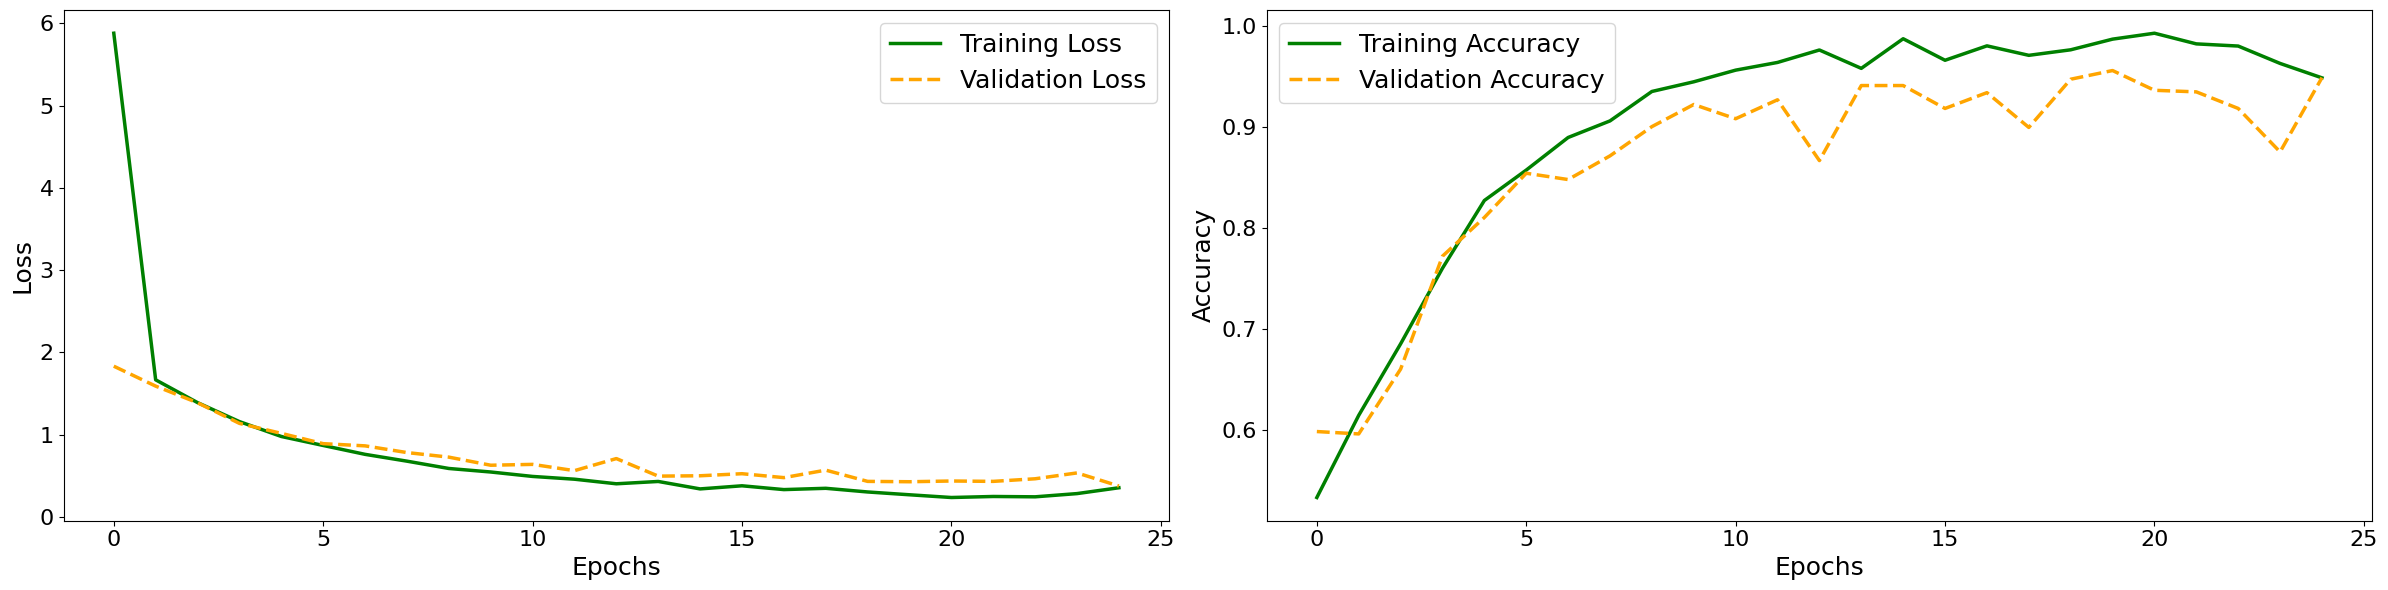

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_custom_CNN.pkl'
history = load_pickle_s3(bucket_name, s3_file_name, dbutils)
clear_output(wait=False)

visualize_training(history)

Predict test data, evaluate accuracy and visualize


Overall classification accuracy is: 94.84 %



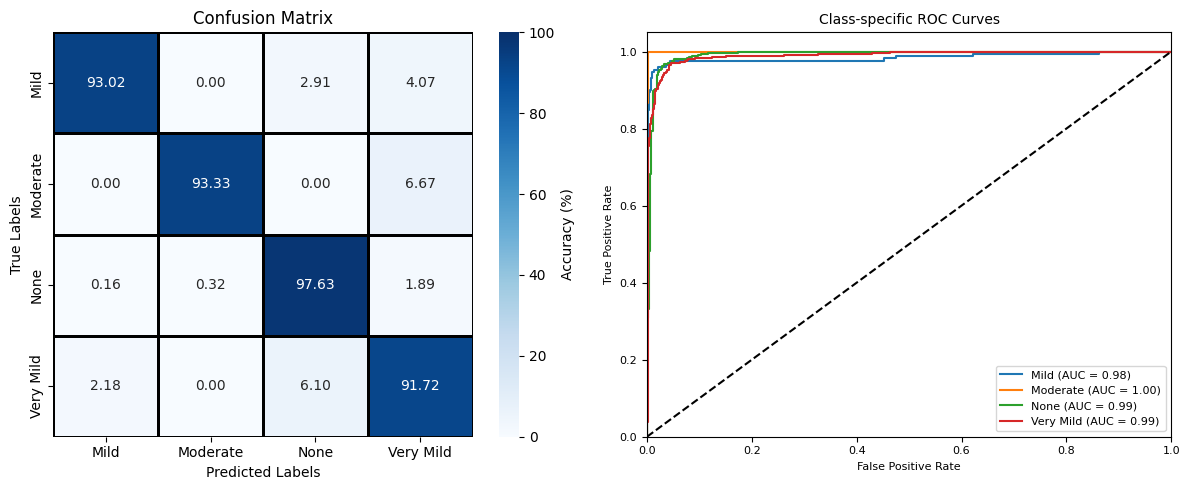

Mild - Precision: 0.94, Recall: 0.93, F1 Score: 0.93
Moderate - Precision: 0.88, Recall: 0.93, F1 Score: 0.90
None - Precision: 0.95, Recall: 0.98, F1 Score: 0.96
Very Mild - Precision: 0.95, Recall: 0.92, F1 Score: 0.94



In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/model_custom_CNN.h5'
model = load_model_s3(bucket_name, s3_file_name, dbutils)

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

Overall we do not see here a direct link between the test set class accuracies and the number of measurements in the training set. While the majority class (no AD) exhibited the highest accuracy, the minority class (moderate AD) exhibited the second highest. Regardless, we still have a class imbalance problem that has not been addressed. Next we will compute and train with class weights to account for the imbalance by giving more importance to underrepresented classes during training.

In [ ]:
# Use same model architecture from before
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model_weighted = create_model()
    model_weighted.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab),
    y=train_lab
)
class_weights_dict = dict(zip(np.unique(train_lab), class_weights))

print(class_weights_dict)

# Train with class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history_weighted = model_weighted.fit(
    train_data,
    train_lab_cat,
    epochs=10,
    batch_size=32,
    validation_data=validation_data,
    callbacks=[early_stopping],
    class_weight=class_weights_dict)

In [ ]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_weighted.h5'
save_model_s3(model_weighted, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_weighted.pkl'
save_pickle_s3(history_weighted, bucket_name, s3_file_path, dbutils)

Visualize weighted model fit

In [ ]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_custom_CNN_weighted.pkl'
history_weighted = load_pickle_s3(bucket_name, s3_file_name, dbutils)
clear_output(wait=False)

visualize_training(history_weighted)

Predict test data, evaluate accuracy and visualize

In [ ]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/model_custom_CNN_weighted.h5'
model_weighted = load_model_s3(bucket_name, s3_file_name, dbutils)

# Predict test data
prob = model_weighted.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

In addition to addressing class imbalance via class weighting, this before examples use a custom CNN with default parameters. As was done with the Random Forest classifier, we can tune the parameters of this model to further optimize performance. Here we redefine the CNN exactly as was done before, but now also specify the parameter space associated with different hyperparameters that we want to tune.

In [0]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

Initiate tuner

In [0]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory='/Workspace/Users/bjedelma@gmail.com', project_name='AD_class')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /Workspace/Users/bjedelma@gmail.com/AD_class/tuner0.json


Run search

In [0]:
# Tune parameters on subset of data to conserve time/memory
subset = []
for label in np.unique(train_lab):
    label_indices = np.where(train_lab == label)[0]
    np.random.shuffle(label_indices)
    subset.extend(label_indices[:int(0.25 * len(label_indices))])
subset = np.array(subset)
train_data_tune = train_data[subset,:,:]
train_lab_tune = train_lab[subset]

# Plot bar graph of label distribution in subset
label_counts = np.bincount(train_lab_tune)
labels = np.arange(len(label_counts))

train_lab_tune_cat = to_categorical(train_lab_tune.astype('int8'))
test_data_tune = test_data
test_lab_tune_cat = to_categorical(test_lab.astype('int8'))

# Compute class weights
class_weights_tune = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab_tune),
    y=train_lab_tune
)
class_weights_dict_tune = dict(enumerate(class_weights_tune))

In [0]:
tuner.search(
    train_data_tune,
    train_lab_tune_cat,
    epochs = 10,
    callbacks = [stop_early],
    validation_data = (test_data_tune, test_lab_tune_cat),
    class_weight = class_weights_dict_tune,
)

Trial 30 Complete [00h 41m 40s]
val_accuracy: 0.589062511920929

Best val_accuracy So Far: 0.7109375
Total elapsed time: 05h 39m 48s


Even though this accuracy is lower than expected given the previous results, tuning was performed on a subset of training data and with limited training epochs to conserve time and memory. Nevertheless, training data was randomly sampled and should be representative of the total dataset. Therefore, we will use the best hyperparameters found here for further model training.

In [0]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Save best hyperparameters
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/best_hps_custom_CNN.pkl'
save_pickle_s3(best_hps, bucket_name, s3_file_path, dbutils)

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/best_hps_custom_CNN.pkl


In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/best_hps_custom_CNN.pkl'
best_hps = load_pickle_s3(bucket_name, s3_file_path, dbutils)

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 3 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('dense_1_units')}

Learning Rate: {best_hps.get('learning_rate')}
""")


Optimal parameters are as follows:

Filter 1 output dim: 96
Filter 2 output dim: 64
Filter 3 output dim: 128

Dense layer units: 224

Learning Rate: 0.0001



Re-train with full training data and optimal hyperparameters

In [0]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    train_lab_cat,
    epochs = 25,
    callbacks = [stop_early],
    validation_data = (test_data, test_lab_cat),
    )

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_best_hp.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_best_hp.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_custom_CNN_best_hp.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_custom_CNN_best_hp.pkl


Best epoch: 20


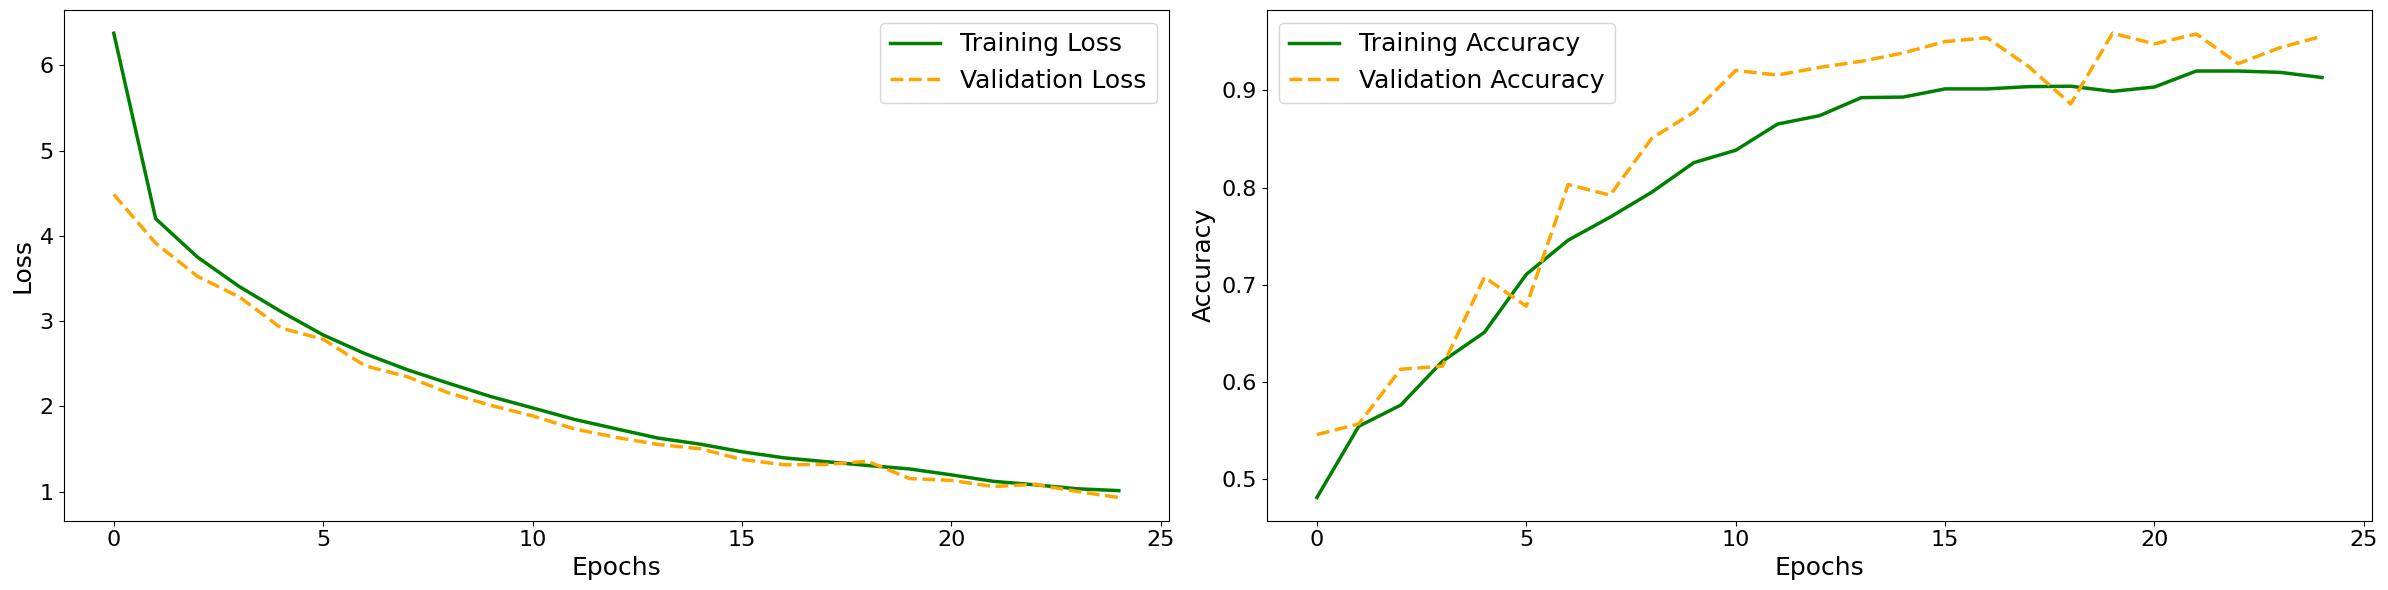

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_best_hp.pkl'
history = load_pickle_s3(bucket_name, s3_file_path, dbutils)
clear_output(wait=False)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

visualize_training(history)

When compared to the original training strategy, that with optimal hyperparameters clearly maximizes the test accuracy across training. However, lets examine model fit in more detail.


Overall classification accuracy is: 95.55 %



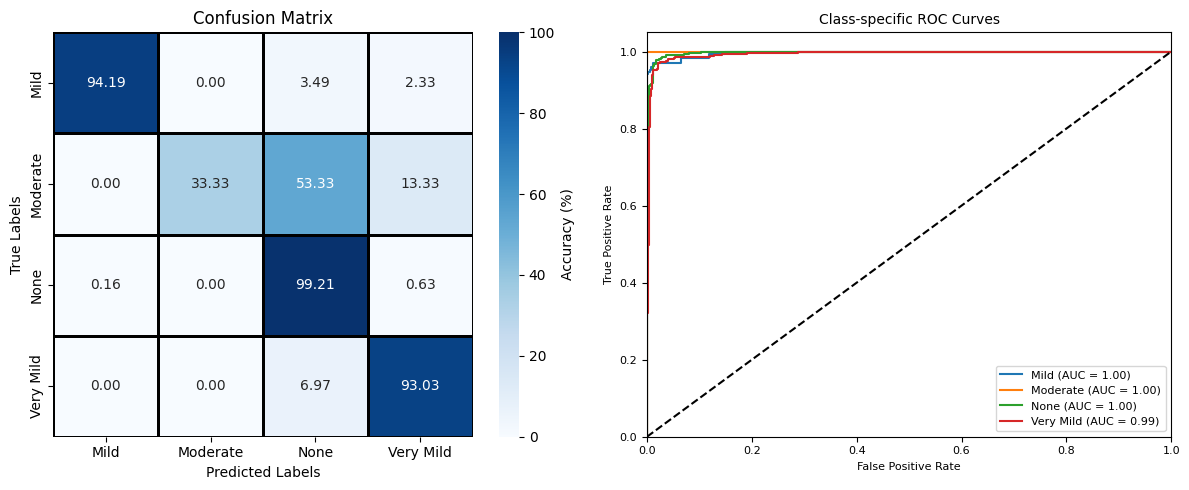

Mild - Precision: 0.99, Recall: 0.94, F1 Score: 0.97
Moderate - Precision: 1.00, Recall: 0.33, F1 Score: 0.50
None - Precision: 0.93, Recall: 0.99, F1 Score: 0.96
Very Mild - Precision: 0.98, Recall: 0.93, F1 Score: 0.95



In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_best_hp.h5'
model=load_model_s3(bucket_name, s3_file_path, dbutils)

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

Even thought hyperparameter tuning (slightly) improved overall classification accuracy, we now see that there is significant bias on a per-class basis. In particular, the moderate AD class, which by far the minority class in the entire dataset, clearly exhibits the worst performance and is difficult to distinguish from no AD. This is problematic since these conditions are on the opposite ends of the AD spectrum in this dataset. Ideally, we devise a model that can distinguish all classes.